Me and my collegues did this challenge as a group.  Carmen Wiggins,Kathleen snider,Michelle Petras

Part 1: Analyze and Explore the Climate Data

In [74]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter

In [75]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [76]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,text,Column,Integer,String,Float,MetaData,inspect,desc
from sqlalchemy.ext.declarative import declarative_base
from datetime import datetime, timedelta


In [77]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [78]:
# I downloaded SQLiteViewer to see the table names in the sqlite. Other way of seeing tables is inpsector .

# Query All Records in the the Database -- connecting sqlite and pandas
engine.execute(text('SELECT * FROM measurement LIMIT 5')).fetchall()
engine.execute(text('SELECT * FROM station LIMIT 5')).fetchall()


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [79]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [80]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(autoload_with=engine)


In [81]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [82]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [83]:
# Display the columns for the measurement table.
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [84]:
# Find the most recent date in the data set.

     
most_recent_record = session.query(measurement).order_by(func.datetime(measurement.date).desc()).first()
most_recent_record.date


'2017-08-23'

In [85]:
#convert to date type
most_recent_date = datetime.strptime(most_recent_record.date, '%Y-%m-%d').date()
#- timedelta(days=365)
date_12_months_ago = most_recent_date - timedelta(days=365)
date_12_months_ago
# Perform a query to retrieve the data and precipitation scores
last_12_months_records = session.query(measurement).filter(
        func.datetime(measurement.date) >= date_12_months_ago
       
    ).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
data = {'date' :[],'precipitation_Score':[]}
# convert the records to dataframe
for record in last_12_months_records:
    data['date'].append(record.date)
    data['precipitation_Score'].append(record.prcp)

df = pd.DataFrame(data)
# Sort the dataframe by date
df_sorted = df.sort_values(by='date')
print(df_sorted)



            date  precipitation_Score
0     2016-08-23                 0.00
1009  2016-08-23                  NaN
1529  2016-08-23                 1.79
704   2016-08-23                 0.05
361   2016-08-23                 0.15
...          ...                  ...
1527  2017-08-22                 0.00
1008  2017-08-23                 0.00
360   2017-08-23                 0.00
1528  2017-08-23                 0.08
2229  2017-08-23                 0.45

[2230 rows x 2 columns]


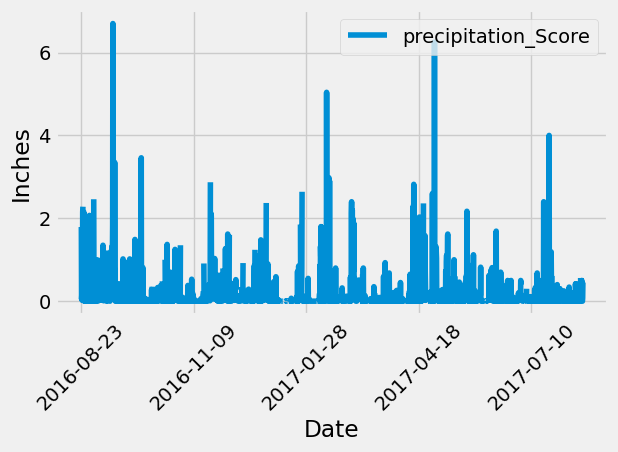

In [86]:
# Use Pandas Plotting with Matplotlib to plot the data
df_sorted.plot(x='date', y='precipitation_Score', rot=45)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [87]:
stats_prcp = df_sorted.describe()
stats_prcp

,precipitation_Score
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [88]:
# Find the columns and types for further Analysis
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [89]:
# Design a query to calculate the total number of stations in the dataset
count_station = session.query(station).count()
count_station

9

In [90]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [measurement.station, 
       func.count(measurement.id).label('count'), 
       ]
station_id_count = session.query(*sel).\
     group_by(measurement.station).\
    order_by(desc('count')).all()
station_id_count


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [91]:
sel = [measurement.station,  
       func.min(measurement.tobs), 
       func.max(measurement.tobs),
       func.avg(measurement.tobs),
      ]
station_stats = session.query(*sel).\
    filter( measurement.station == "USC00519281").all()
   
station_stats

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [92]:
most_recent_record = session.query(measurement).filter(measurement.station == 'USC00519281').order_by(func.datetime(measurement.date).desc()).first()
most_recent_record.date

'2017-08-18'

Text(0.5, 4.183333333333314, 'Temperature')

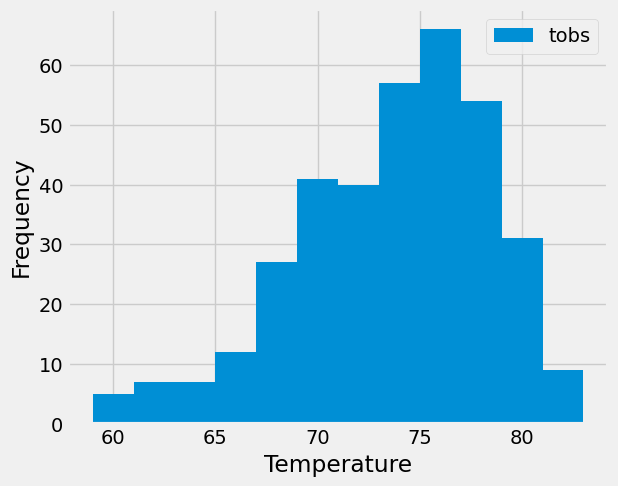

In [93]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_recent_record = session.query(measurement).filter(measurement.station == 'USC00519281').order_by(func.datetime(measurement.date).desc()).first()
most_recent_record.date
most_recent_date = datetime.strptime(most_recent_record.date, '%Y-%m-%d')
#- timedelta(days=365)
date_12_months_ago = most_recent_date - timedelta(days=365)
date_12_months_ago
# Perform a query to retrieve the data and precipitation scores
last_12_months_tobs = session.query(measurement.tobs).\
     filter(measurement.station == 'USC00519281').\
     filter(func.datetime(measurement.date) >= date_12_months_ago).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(last_12_months_tobs,columns=['tobs'])
# convert the records to dataframe

df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")



# Close Session

In [94]:
# Close Session
session.close()